# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'

# Universe

In [3]:
WidgetUniverse

*universe and file*

In [4]:
uv_k200 = ['kospi200', 'kospi200_prices_100104_240707.csv']
uv_k2hl = ['krx', 'kospi200_bt_prices_040102_241023.csv']
uv_krx = ['krx', 'krx_prices.csv']

## KRX

In [5]:
krx = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_krx))
)
krx.upload()

2712 assets from 2019-01-02 to 2024-10-08 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
#krx.download(**kw) if WidgetUniverse.values(0) else None

In [7]:
df_krx = krx.df_prices
assetnames_krx = krx.get_names()

ERROR from get_names: '164060'


### KOSPI

In [8]:
from pf_utils import KRXDownloader
market = 'KOSPI'
krxd = KRXDownloader(None)
krxd.get_tickers(market)
assets_kospi = krxd.tickers

In [9]:
df_kospi = df_krx[df_krx.columns.intersection(assets_kospi)]

## KOSPI200

In [5]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

200 assets from 2010-01-04 to 2024-07-05 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1)
)
k200.download(**kw) if WidgetUniverse.values(0) else None

In [7]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

### Data Size

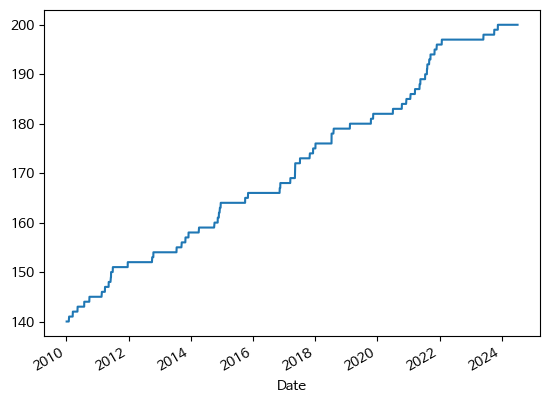

In [8]:
_ = df_k200.unstack().dropna().groupby('Date').count().plot()

In [9]:
start = '2020'
df_k200.loc[start:].dropna(axis=1).columns.size

182

In [10]:
df_k200 = df_k200.loc[start:]
len(df_k200)

1113

## K2HL
Approximate historicals of KOSPI200 for bactesting

In [16]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [17]:
df_k2hl = k2hl.df_prices
assetnames_k2hl = k2hl.get_names()

ERROR from get_names: '060000'


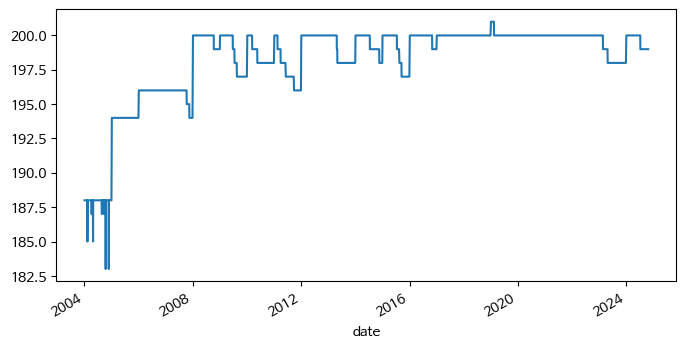

In [18]:
_ = df_k2hl.notna().sum(axis=1).plot(figsize=(8,4))

*stocks remaining in the universe to track portfolio positions*

In [19]:
cond = (df_k2hl.ffill() != df_k2hl).sum() == 0
cond.sum() / df_k2hl.columns.size

0.14084507042253522

In [20]:
df_k2hl = df_k2hl.ffill()

# Parameter Study

## KOSPI200

In [11]:
n_val = 200
lookback = 260
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [12]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

### Cross-validate

In [13]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [10,20],
    p_freq = [20,40,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg10/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 10,
 'freq': 20}

In [16]:
bm = BacktestManager(df_train, **kwargs_bm)

200 assets from 2020-01-02 to 2023-09-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [17]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

8 jobs prepared for cross-validation


In [ ]:
bm.cross_validate(n_sample=20)

### Visualize

In [21]:
file = 'param_momentum_k200.csv'

In [ ]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

*Load param study*

In [22]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_k200.csv
54 param sets with 18 iterations per set


In [24]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv, name='KODEX200')

Returning cagr of KODEX200 from 2020-01-02 to 2023-09-07


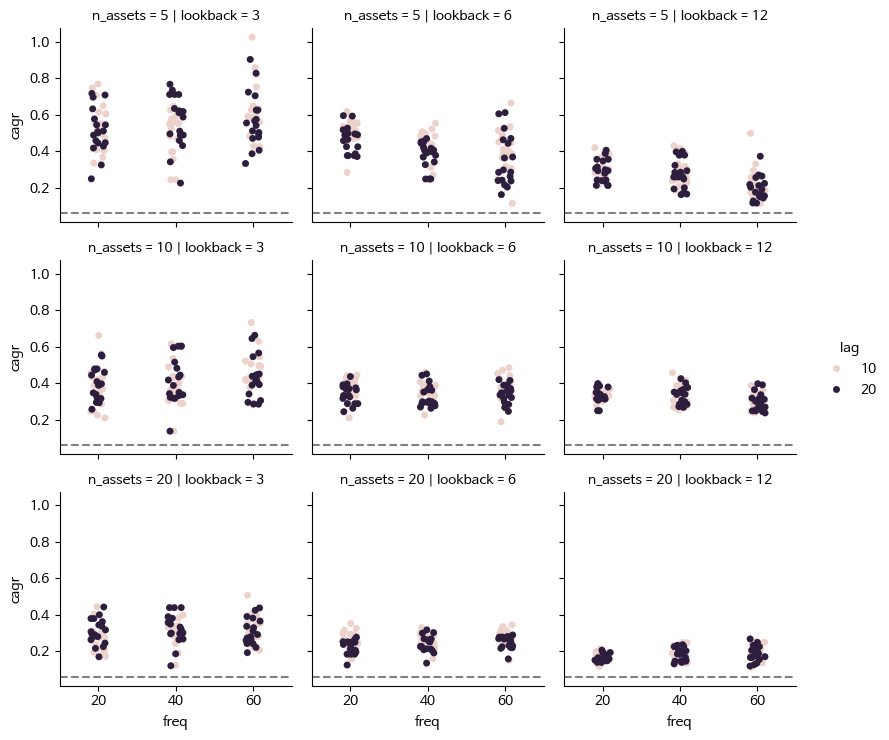

In [25]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}
#kw = {'x':'freq', 'col':'n_assets', 'row':'lookback', 'hue':'lag'}
#kw = {'x':'freq', 'col':'n_assets', 'row':'lookback', 'kind':'box'}
kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=2.5, aspect=1.1, **kw)

### Validation

In [13]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=3, lag=10)
bm.benchmark_ticker(**lags)

200 assets from 2022-08-23 to 2024-07-05 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [14]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[5, 3, 10, 20], [20, 12, 20, 60], [5, 12, 5, 20]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 4 strategies: KODEX200, MOM:n5/lb3/lg10/f20, MOM:n20/lb12/lg20/f60, MOM:n5/lb12/lg5/f20


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.33it/s]

Returning stats


,MOM:n5/lb3/lg10/f20,MOM:n5/lb12/lg5/f20,KODEX200,MOM:n20/lb12/lg20/f60
start,2022-08-22,2022-08-22,2022-08-22,2022-08-22
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,1.52734,0.846402,0.306234,0.204645
cagr,0.641851,0.388111,0.153573,0.104692
calmar,2.606932,1.630178,1.216402,0.98381
max_drawdown,-0.246209,-0.238079,-0.126252,-0.106415
avg_drawdown,-0.071619,-0.048359,-0.029609,-0.02516
avg_drawdown_days,21.347826,14.235294,23.181818,11.8
daily_vol,0.419157,0.307866,0.149202,0.106218
daily_sharpe,1.418745,1.240916,1.055501,1.013265


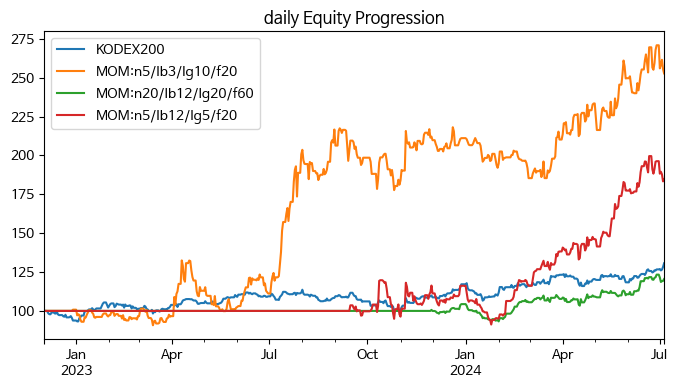

In [15]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(8,4))

## KOSPI

In [32]:
len(df_kospi)

1420

In [33]:
n_val = 200
lookback = 260
df = df_kospi
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [34]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

### Cross-validate

In [8]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [20],
    p_freq = [20, 60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg20/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 20,
 'freq': 20}

In [ ]:
bm = BacktestManager(df_train, **kwargs_bm)

In [ ]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

In [59]:
bm.cross_validate(n_sample=20)

Cross-validating 18 strategies: MOM:n5/lb3/lg20/f20, MOM:n5/lb3/lg20/f60, ... , MOM:n20/lb12/lg20/f60


100%|███████████████████████████████████████████████████████████████| 19/19 [01:00<00:00,  3.17s/it]


18.0 mins elapsed, 0.0 secs paused (0.0%)


### Visualize

In [35]:
file = 'param_momentum_kospi.csv'

In [60]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_momentum_kospi.csv saved


*Load param study*

In [36]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_kospi.csv
18 param sets with 19 iterations per set


In [37]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv, name='KODEX200')

Returning cagr of KODEX200 from 2019-01-02 to 2023-12-08


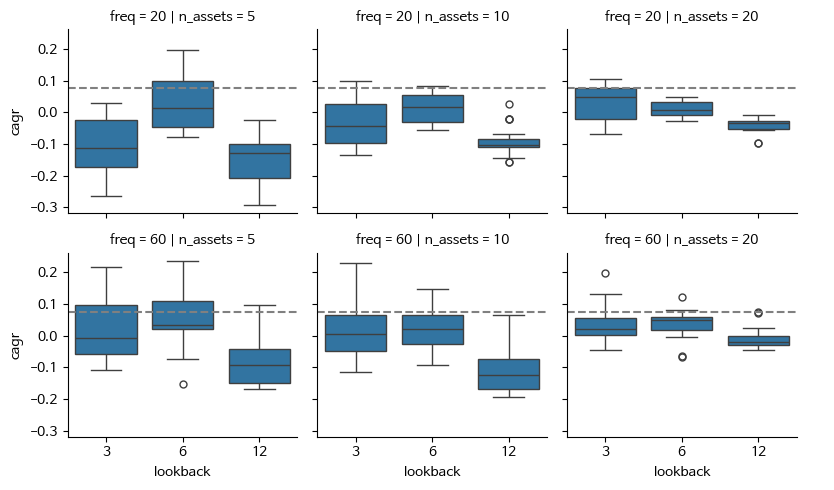

In [38]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback'}
kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'kind':'box'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=2.5, aspect=1.1, **kw)

### Validation

In [39]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=3, lag=20)
bm.benchmark_ticker(**lags)

946 assets from 2022-11-22 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [40]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[20, 3, 20, 20], [20, 12, 20, 60]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 3 strategies: KODEX200, MOM:n20/lb3/lg20/f20, MOM:n20/lb12/lg20/f60


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.72it/s]

Returning stats


,KODEX200,MOM:n20/lb12/lg20/f60,MOM:n20/lb3/lg20/f20
start,2022-11-21,2022-11-21,2022-11-21
end,2024-10-08,2024-10-08,2024-10-08
total_return,0.134857,0.002149,-0.319923
cagr,0.069572,0.001142,-0.185337
calmar,0.422206,0.003969,-0.403138
max_drawdown,-0.164782,-0.287771,-0.459737
avg_drawdown,-0.027873,-0.04414,-0.160377
avg_drawdown_days,19.269231,14.230769,132.5
daily_vol,0.16847,0.208026,0.288931
daily_sharpe,0.496304,0.110924,-0.585895


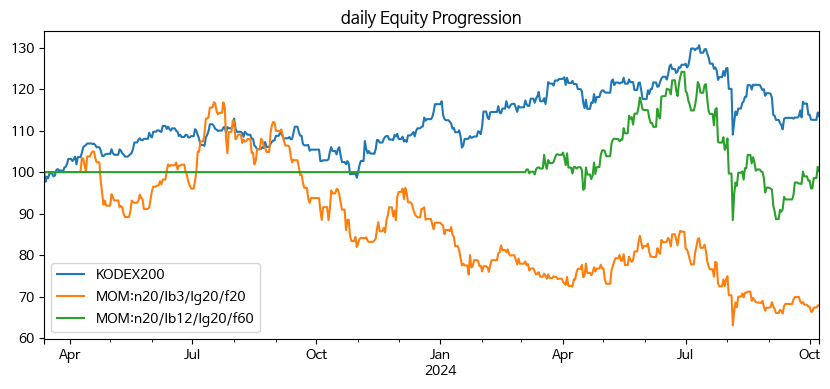

In [41]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

## K2HL

In [42]:
len(df_k2hl)

5142

In [43]:
df = df_k2hl
n_val = 500
lookback = 260
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [44]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k2hl
)

### Cross-validate

In [26]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [10,20],
    p_freq = [20,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg10/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 10,
 'freq': 20}

In [27]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2022-10-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [13]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True, build_cv=True
)
bm.build_batch(*kwa_list, **kwargs_build)

36 jobs prepared for cross-validation


In [16]:
kw_batch = dict(size_batch=5, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 36 strategies: MOM:n5/lb3/lg10/f20, MOM:n5/lb3/lg10/f60, ... , MOM:n20/lb12/lg20/f60
25 jobs done before


100%|███████████████████████████████████████████████████████████████| 20/20 [04:29<00:00, 13.46s/it]


50.2 mins elapsed, 0.0 secs paused (0.0%)


### Visualize

In [45]:
file = 'param_momentum_k2hl.csv'

*Save param study*

In [ ]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

*Load param study*

In [46]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_k2hl.csv
36 param sets with 20 iterations per set


In [47]:
y = 'cagr'
ref_val = bm.benchmark_stats(y, data=df_cv, name='KODEX200')

Returning cagr of KODEX200 from 2004-01-02 to 2022-10-07


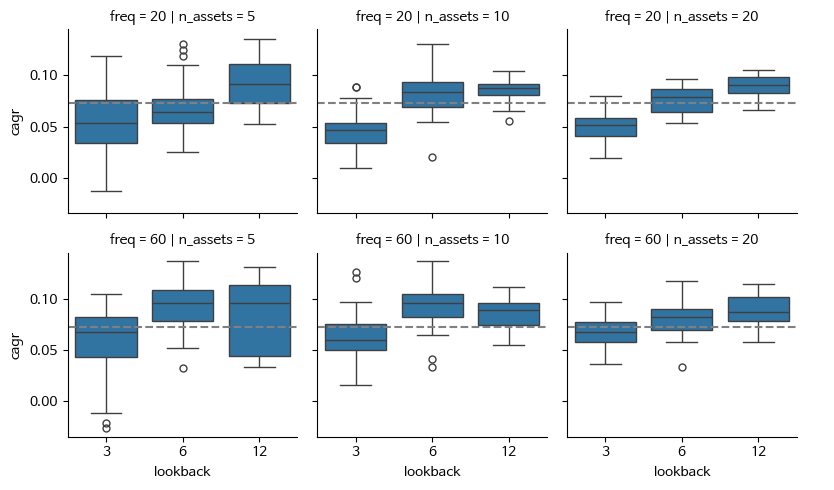

In [48]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback'}
kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'kind':'box'}
#kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'hue':'lag'}

_ = bm.catplot(data=df_cv, y=y, ref_val=ref_val, height=2.5, aspect=1.1, **kw)

### Validation

In [21]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=12, lag=20)
bm.benchmark_ticker(**lags)

426 assets from 2021-09-15 to 2024-10-23 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [22]:
# n_assets, lookback(M), lag(D), freq(D)
#p_comb = [[5, 12, 10, 20], [5, 12, 5, 20], [20, 12, 20, 20]]
p_comb = [[5, 12, 20, 20], [5, 12, 5, 20], [20, 12, 20, 20]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 4 strategies: KODEX200, MOM:n5/lb12/lg20/f20, MOM:n5/lb12/lg5/f20, MOM:n20/lb12/lg20/f20


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.14it/s]

Returning stats


,MOM:n20/lb12/lg20/f20,KODEX200,MOM:n5/lb12/lg5/f20,MOM:n5/lb12/lg20/f20
start,2021-09-14,2021-09-14,2021-09-14,2021-09-14
end,2024-10-23,2024-10-23,2024-10-23,2024-10-23
total_return,0.323528,0.257359,0.186579,-0.02425
cagr,0.094396,0.076482,0.056596,-0.007869
calmar,0.390376,0.46418,0.125927,-0.016139
max_drawdown,-0.241807,-0.164767,-0.449439,-0.48759
avg_drawdown,-0.049819,-0.031448,-0.075089,-0.116526
avg_drawdown_days,39.470588,22.931034,53.230769,87.125
daily_vol,0.180193,0.148929,0.288067,0.272356
daily_sharpe,0.606105,0.58484,0.340969,0.10637


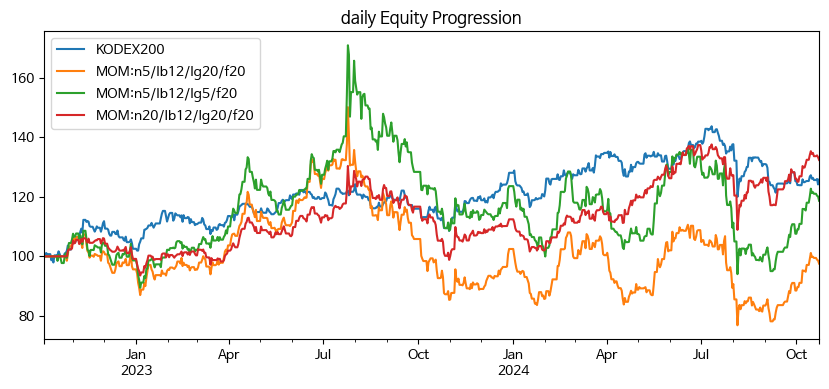

In [23]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

# testing

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager, MomentumPortfolio
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'
path_tran = 'transaction'

*data for backtesting*

In [3]:
file_bt_price = 'kospi200_bt_prices_040102_241023.csv'
file_bt_ratio = 'kospi200_bt_ratios_040131_240930.csv'

# Data

## Price

In [4]:
file = 'kospi200_prices.csv'

*Uncomment for backtesting*

In [5]:
file = file_bt_price

In [6]:
k200 = DataManager(
    universe = 'kospi200',
    file = file,
    path = path_data
)
k200.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [7]:
df_k200 = k200.df_prices.ffill()
assetnames_k200 = k200.get_names()

ERROR from get_names: '060000'


## Ratios

In [8]:
WidgetUniverse

In [9]:
is_backtest = True if k200.file_historical == file_bt_price else False

In [10]:
file = 'kospi200_ratios.csv' if not is_backtest else file_bt_ratio
fr = FinancialRatios(file, path_data)

Financial ratios of 426 stocks from 2004-01-31 to 2024-09-30 loaded


## Reshape
Interpolate & Reshape for backtesting

In [13]:
df_p = fr.util_reshape(df_k200)

In [15]:
df_k200 = df_k200.loc['2010':]
cols = df_k200.columns.intersection(fr.df_ratios.index.get_level_values(0).unique())
df_p = fr.util_reshape(df_k200[cols])

In [30]:
import pandas as pd
idx = pd.IndexSlice
fr.df_ratios = fr.df_ratios.sort_index().loc[idx[:,'2010':],:]

cols = df_k200.columns.intersection(fr.df_ratios.index.get_level_values(0).unique())
df_p = fr.util_reshape(df_k200[cols])

In [11]:
import pandas as pd
idx = pd.IndexSlice

df_k200 = df_k200.loc[:'2010-12-31']
fr.df_ratios = fr.df_ratios.sort_index().loc[idx[:,'2011-01-01':],:]

cols = df_k200.columns.intersection(fr.df_ratios.index.get_level_values(0).unique())
df_p = fr.util_reshape(df_k200[cols])

In [57]:
import pandas as pd
idx = pd.IndexSlice

df_k200 = df_k200.loc['2011-01-01':]
fr.df_ratios = fr.df_ratios.sort_index().loc[idx[:,:'2010-12-31'],:]

cols = df_k200.columns.intersection(fr.df_ratios.index.get_level_values(0).unique())
df_p = fr.util_reshape(df_k200[cols])

In [12]:
fratios_dict = dict()
for r in ['PER']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

ERROR: no intersection of dates btw price and ratios
ERROR: 'NoneType' object has no attribute 'unstack'


In [60]:
#fratios_dict[r]

In [132]:
from pf_utils import get_date_minmax

#def interpolate(

self = fr
sr_prices = df_p
metric='PER'
freq='M'

"""
calculates an interpolated ratio for sr_prices
sr_prices: series of price with index of (ticker, date)
"""
col_ticker = self.cols_index['ticker']
col_date = self.cols_index['date']
col_price = 'price'
col_mpl = 'multiplier'
col_ym = 'year_month'

df_ratios = self.df_ratios
if df_ratios is None:
    print('ERROR: load ratios first')
    
# Copy metric column to avoid modifying original
df_m = df_ratios[metric].copy()

# check if ratios missing
gtck = lambda x: x.index.get_level_values(0).unique()
n = gtck(sr_prices).difference(gtck(df_m)).size 
if n > 0:
    print(f'ERROR: ratios of {n} stocks missing')

# check frequency
if not self._check_freq(df_ratios, col_date, n_in_year=12):
    print('WARNING: No interpolation as data is not monthly')
    df_m

# set price date range with metric range
start_date, end_date = get_date_minmax(df_m, level=1)

In [ ]:
if freq.lower() == 'm':
    end_date = end_date + pd.DateOffset(months=1)
else:
    pass #raise NotImplementedError

# get multiplier to calc ratio from price
i0 = df_m.index.get_level_values(0).unique()
i1 = pd.date_range(start=start_date, end=end_date)
idx = pd.MultiIndex.from_product([i0, i1], names=df_m.index.names)
df_m = (sr_prices.to_frame(col_price)
        .join(df_m, how='outer').ffill()  # combine all dates of both price and ratio
        .apply(lambda x: x[metric] / x[col_price], axis=1).rename(col_mpl) # calc multiplier
        .loc[df_m.index].to_frame(col_mpl) # slice multipliers with dates in ratio
        # ffill multipliers from start_date and end_date
        .join(pd.DataFrame(index=idx), how='right').ffill()
)

# interpolate ratio
idx = pd.IndexSlice
df_res = (sr_prices.loc[idx[:, start_date:end_date]]
          .to_frame(col_price)
          .join(df_m) # join with ratio multiplier
          .apply(lambda x: x[col_price] * x[col_mpl], axis=1)
          .rename(metric)
         )
dt0, dt1 = get_date_minmax(df_res, self.date_format, 1)
print(f'{metric} interpolated from {dt0} to {dt1}')
df_res

ValueError: NaTType does not support strftime

In [129]:
df_res

Series([], Name: PER, dtype: float64)

In [130]:
df_p

ticker  date      
000020  2004-01-02     1350.0
        2004-01-05     1356.0
        2004-01-06     1362.0
        2004-01-07     1352.0
        2004-01-08     1348.0
                       ...   
105560  2010-12-24    58500.0
        2010-12-27    59500.0
        2010-12-28    58900.0
        2010-12-29    59500.0
        2010-12-30    60000.0
Length: 406763, dtype: float64

In [133]:
df_m

ticker  date      
000020  2012-01-31      21.06
        2012-02-29      24.74
        2012-03-31      24.48
        2012-04-30      23.74
        2012-05-31       7.87
                       ...   
450080  2024-05-31    1350.59
        2024-06-30     931.76
        2024-07-31    1143.53
        2024-08-31    1016.47
        2024-09-30    1117.65
Name: PER, Length: 55854, dtype: float64

In [134]:
start_date, end_date

(Timestamp('2012-01-31 00:00:00'), Timestamp('2024-09-30 00:00:00'))